In [1]:
# !pip install geopandas
# !pip install pgeocode
# !pip install folium
# !pip install pyshp
# !pip install haversine
!pip install k-means-constrained
# !pip install k-means-constrained --target /opt/conda/lib/python3.8/site-packages
# !pip install --upgrade numpy --target /opt/conda/lib/python3.8/site-packages

In [9]:
!pip install --upgrade sklearn --target /opt/conda/lib/python3.8/site-packages
# !pip install --upgrade numpy --target /opt/conda/lib/python3.8/site-packages

     |████████████████████████████████| 26.7 MB 30.8 MB/s eta 0:00:01
  Using cached scipy-1.7.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (39.3 MB)
  Using cached numpy-1.22.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=f1c5069fb7708488583ac4419bee7804d93cdfafcc8a7a46c0431a35d18038ea
  Stored in directory: /home/jovyan/.cache/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.4.1 requires absl-py~=0.10, but you have absl-py 1.0.0 which is incompatible.
tensorflow 2.4.1 requires numpy~=1.19.2, but you have numpy 1.22.1 which is incompatible.
tensorflow 2.4.1 requires six~=1.

In [2]:
# 1) Get fake jobs for zipcodes in Orlando
# 2) Get problem descriptions for the jobs and predict parts START HERE
# 3) Create part stock list - top 10 model ice maker kits
# 4) Flag same day fix
# 5) run against current availibility mapping with agents

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import random
import sqlalchemy, os
import pandas as pd
import numpy as np
np.random.seed(201912)
import matplotlib.pyplot as plt
from datetime import datetime as dt
import pickle
from retail_toolkit import atlas
from retail_toolkit import credential_manager as cm
from numpy import average
import time

In [3]:
import requests
import json
from collections import Counter
from random import choices

In [47]:
import folium
from folium.plugins import HeatMap
# import geopandas as gpd
from shapely.geometry import Point, Polygon
import shapefile
from IPython.display import display

In [5]:
from k_means_constrained import KMeansConstrained
from folium import plugins

In [6]:
import pgeocode
from haversine import haversine, Unit

In [7]:
# Applying simple kmeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt

In [8]:
def analysis(lat1, long1, lat2, long2):
#     This function gets time taken to traven and distance between two points using OSRM package
# The server on ip 100.70.175.6 has to be started before executing code below. Please contact Suresh to turn it on. 
    time.sleep(3)
    url = 'http://100.70.175.6:5000/route/v1/driving/{},{};{},{}'
    r = requests.get(url.format(long1,lat1,long2,lat2)).text
    data = json.loads(r)
    try:
        distance = round(data["routes"][0]["distance"]*0.621371/1000, 1)
        duration = round(data["routes"][0]["duration"]/60, 1)
        return([distance,duration])
    except KeyError:
        return([-1.0,-1.0])

In [9]:
def function_distance(group, clusters_centroid):
    empty_list = []
    loc1 = clusters_centroid
#     print(loc1)
    for index, i in group.iterrows():
        loc2 = (float(i['zip_lat']),float(i['zip_lon']))
#         print(loc2)
        empty_list.append(haversine(loc1,loc2,unit=Unit.MILES))
    return(empty_list)

def dist_from_centroid(group, centroid):
    empty_list = []
    for index, each in group.iterrows(): 
        empty_list.append(haversine(centroid, (each['zip_lat'],each['zip_lon'] ), unit='mi'))
    return(empty_list)

def popu_in_30_mins(s_df):
    # This function gets all zip codes within 30mins driving distance of each zip and sums the population.
    empty_list = []
    for index, each in s_df.iterrows():
    #     print(each.cust_zip)
        demand_within_30mins = 0
        for index, row in s_df.iterrows():
    #         print(analysis(each.Latitude,each.Longitude, row.Latitude,row.Longitude))
            if analysis(each.lat_zip,each.lon_zip, row.lat_zip,row.lon_zip)[1] <= 30.0:
    #             print(analysis( each.Longitude,each.Latitude,  row.Longitude,row.Latitude)[1])
    #             print(each.claim_volume)
                demand_within_30mins = demand_within_30mins+row.Population
    #             print(demand_within_30mins)
    #     print(demand_within_30mins)
        empty_list.append(demand_within_30mins)
    return(empty_list)

In [10]:
url = 'http://100.70.180.199:8080/search'

def geocode_address(row):
    params = {
        'street': row.addr_line_1,
        'city': row.address_city,
        'state': row.addr_state,
        'postalcode': row.cust_zip
    }
    # print(params)
    res = requests.get(url, params=params)
    if res and res.json():
#         print('used adre, city, state')
        return [res.json()[0]['lat'], res.json()[0]['lon']]

#skipping city from parameters increases wrong cordinate rates
#     params = {
#         'street': row.addr_line_1,
#         'state': row.addr_state,
#         'postalcode': row.cust_zip
#     }
#     res = requests.get(url, params=params)
#     if res and res.json():
# #         print('street, state')
#         return [res.json()[0]['lat'], res.json()[0]['lon']]
    
    params = {
        'city': row.address_city,
        'state': row.addr_state,
        'postalcode': row.cust_zip
    }
    res = requests.get(url, params=params)
    if res and res.json():
#         print('city, state')
        return [res.json()[0]['lat'], res.json()[0]['lon']]

    params = {
        'street': row.addr_line_1,
        'city': row.address_city,
        'state': row.addr_state
    }
    res = requests.get(url, params=params)
    if res and res.json():
#         print('city, state')
        return [res.json()[0]['lat'], res.json()[0]['lon']]
    else:
        return 'error'

def geocode_zipcode(row):
    params = {
        'postalcode': row.cust_zip
    }
    # print(params)
    res = requests.get(url, params=params)
    if res and res.json():
#         print('used adre, city, state')
        return [res.json()[0]['lat'], res.json()[0]['lon']]
    else:
        return 'error'

In [11]:
presto_connection =  atlas.Presto(environment = 'presto://{}:{}@atlas-workbench-presto.atlas.prd.aws.asurion.net:18443/hive').connect()

In [12]:
# geo_sql = "select * from hive.rtm_analytics.l3_retail_scm_m_geography"
# geo_cordinates = pd.read_sql(geo_sql, presto_connection)

In [13]:
sql = """
select distinct
	sj.service_order_id ,
	so.service_order_number,
	sj.service_job_type_id ,
	sj.payment_type ,
	sj.sj_program_id ,
	sj.external_reference_number ,
	sj.crm_number ,
	sj.service_job_id ,
	sj.service_job_number ,
	sj.service_job_status ,
	sj.service_job_sub_status ,
	sj.service_job_date,
	sj.service_job_source ,
	sj.service_request_type_code ,
	sj.technician_routing_status ,
	sj.technician_routing_message ,
	sj.route_order_number ,
	sj.scheduled_service_date,
	coalesce(o.orig_sched_dt, sj.scheduled_service_date) orig_service_dt ,
	sj.problem_description ,
	sj.service_explanation ,
	sj.technician_id ,
	rs.retailer_store_name,
	sprd.model_number,
	sprd.model_version,
	sprd.serial_number,
	sprd.internal_brand_code ,
	sprd.purchase_date ,
	sprd.purchase_price ,
	sprd.manufacturer ,
	sjpl.description industry,
	ftf.min_tech_arrival_dt,
	ftf.min_complete_dt,
	cus.address_line_1 addr_line_1,
	cus.address_city,
	cus.address_province addr_state,
	cus.address_postal_code addr_zip_code,
    dl.name
from
    hive.rtm_analytics.l2_odhsb_sbv5_at_service_job_rs sj 
	join hive.rtm_analytics.l2_odhsb_sbv5_at_service_order_rs so on so.service_order_id = sj.service_order_id 
	join hive.rtm_analytics.l2_odhsb_sbv5_at_sj_part_rs sjp on sj.service_job_id = sjp.service_job_id
	join hive.rtm_analytics.l2_odhsb_sbv5_at_sa_retailer_store_rs rs on	sj.retailer_store_id = rs.retailer_store_id
	join hive.l2_retail.odhsb_sbv5_at_so_product sprd on sprd.service_order_id = so.service_order_id 
	join hive.l2_retail.odhsb_sbv5_at_sa_service_job_product_line sjpl on sjpl.sj_product_line_id = sprd.sj_product_line_id 
	join hive.l2_retail.odhsb_sbv5_st_txn_contact cus on cus.txn_id = sj.service_order_id and contact_type = 0
    left join hive.l2_retail.odhsb_sb_svbt_dispatch_zone z on sj.sj_zone_id = z.zone_id_char
    left join hive.l2_retail.odhsb_sb_svbt_dealer_location dl on z.dealer_location_id = dl.dealer_location_id
	left join (
		select
			entity_id,
			min(date_parse(old_value , '%%m/%%d/%%Y')) orig_sched_dt
		from
			hive.rtm_analytics.l2_odhsb_sbv5_st_audit_field_rs
		where
			owner_company_id = '43'
			and field_id = 'scheduledServiceDate'
			and cast(audit_date as date) >= date '2021-01-01'
		group by 1
	) o on sj.service_job_id = o.entity_id
	left join (
		select 
			so.service_order_id,
			min(case when au.new_value = 'TAR' then au.audit_dateutc end) min_tech_arrival_dt,
			min(case when au.new_value in ('AAA','AWT','ACU','RTC','AAK','AAJ','ABB','ABC','ACP','ACQ','ACR','ACV') then au.audit_dateutc end) min_complete_dt
		from
			hive.rtm_analytics.l2_odhsb_sbv5_st_audit_field_rs au
		    join rtm_analytics.l2_odhsb_sbv5_at_service_job_rs  sj on au.entity_id = sj.service_job_id
		    join l2_retail.odhsb_sbv5_at_service_order so on so.service_order_id = sj.service_order_id
		    join rtm_analytics.l2_odhsb_sbv5_at_txn_exception_rs e on e.txn_id = sj.service_job_id
		    join rtm_analytics.l2_odhsb_sbv5_at_txn_exception_detail_rs ed on ed.exception_id  = e.exception_id and ed.exception_code = 'PRE_DIAGNOSIS'
		where
			au.owner_company_id = '43'
			and cast(au.audit_date as date) >= date '2021-01-01'
			and au.field_id = 'serviceJobSubStatus'
		group by
			so.service_order_id
	) ftf on ftf.service_order_id = so.service_order_id
where
	--exception_code = 'PRE_DIAGNOSIS'
-- 	and payment_type = 'CASHONDELIVERY'
-- and retailer_store_name = 'Major Appliance - Samsung'
--sjpl.description IN ('HOME REFRIGERATION' , 'HOME LAUNDRY ELEC', 'HOME LAUNDRY GAS', 'DISHWASHER')
	cast(sj.scheduled_service_date as date) >= cast(date_add('month',-12,current_date) as date)
    and sj.service_provider_id in ('1133787699','1116738095','1115480731')
    and sj.service_job_status in ('CMP','ACC')
"""

In [14]:
# 648 jobs in jan

In [15]:
demand = pd.read_sql(sql, presto_connection)

In [16]:
demand.shape

(66787, 38)

In [17]:
# demand.service_order_id.unique().shape

In [18]:
# demand = pd.read_csv('demand_history.csv')
demand = demand[~demand.addr_zip_code.isna()]
demand = demand[demand.addr_zip_code != 'UNKNOWN']
demand['cust_zip'] = demand.addr_zip_code.str[:5]
demand = demand[demand['cust_zip'].apply(lambda x: x.isnumeric())]
demand['cust_zip'] = demand['cust_zip'].astype(int)

In [19]:
demand.name.unique()

array(['RIVERSIDE-OEM', 'PALM SPRINGS', 'SEATTLE', 'ORLANDO',
       'DALLAS-OEM', 'LOS ANGELES-OEM', 'CHATTANOOGA', 'COLUMBUS OH-OEM',
       'FORT MYERS', 'BUFFALO', 'KANSAS CITY', 'ALEXANDRIA', 'MIAMI',
       'JUPITER', 'DAYTONA', 'FORT LAUDERDALE', 'LONG ISLAND WEST',
       'ALEXANDRIA-OEM', 'JACKSONVILLE', 'TAMPA', 'ROCHESTER',
       'HOUSTON-OEM', 'LONG ISLAND EAST', 'GRAND RAPIDS', 'NASHVILLE-OEM',
       'DETROIT-OEM', 'SYRACUSE', 'BOSTON', 'LONG BEACH-OEM', 'CLEVELAND',
       'PITTSBURGH', 'OCALA', 'SAN DIEGO-OEM', 'ATLANTA-OEM',
       'CLEVELAND-OEM', 'RALEIGH-OEM', 'PITTSBURGH-OEM',
       'NEW ORLEANS-OEM', 'ASURION REPAIR SERVICES', 'CHARLESTON-OEM',
       'KANSAS CITY-OEM', 'TALLAHASSEE', 'ODESSA-OEM', 'SAINT LOUIS-OEM',
       'Inactive', None, 'SAN ANTONIO-OEM', 'OKLAHOMA CITY-OEM',
       'SACRAMENTO-OEM', 'MEMPHIS-OEM', 'SAN JOSE-OEM',
       'ASURION MAJOR APPLIANCE LA', 'PORTLAND',
       'ASURION MAJOR APPLIANCE REPAIR'], dtype=object)

In [20]:
#Filter volume to only specific market
demand_orlando = demand[demand.name == 'TAMPA']

In [21]:
demand_orlando.service_order_id.drop_duplicates().shape

(2912,)

In [22]:
demand_orlando = demand_orlando[['service_order_id','service_order_number','crm_number','service_job_number','addr_line_1', 'address_city', 'addr_state', 'addr_zip_code', 'name','cust_zip']].drop_duplicates()
demand_orlando = demand_orlando.groupby(['service_order_id','service_order_number'])[['addr_line_1','address_city','addr_state','cust_zip']].max().reset_index()

In [25]:
demand_orlando['cust_adr_lat_lon'] = demand_orlando.apply(geocode_address, axis = 1)

In [26]:
print(demand_orlando[demand_orlando.cust_adr_lat_lon == 'error'].shape)
demand_orlando_zip = demand_orlando[demand_orlando.cust_adr_lat_lon != 'error']

(13, 7)


In [27]:
demand_orlando_zip['zip_lat'] = demand_orlando_zip['cust_adr_lat_lon'].apply(lambda x: x[0])
demand_orlando_zip['zip_lon'] = demand_orlando_zip['cust_adr_lat_lon'].apply(lambda x: x[1])

In [28]:
# demand_orlando_cust_adr[['lat_adr','lon_adr']] = demand_orlando_cust_adr[['lat_adr','lon_adr']].astype(float)
demand_orlando_zip[['zip_lat','zip_lon']] = demand_orlando_zip[['zip_lat','zip_lon']].astype(float)


In [30]:
# demand_df['Population_w_30mins'] = popu_in_30_mins(demand_df)
# demand_df['perc_population_w_30mins'] = demand_df['Population_w_30mins']/demand_df['Population_w_30mins'].sum()

In [31]:
# demand_df[demand_df.perc_volume>=0.4]['perc_volume'].sum()

In [32]:
# low_volume_zips = demand_df[demand_df.perc_volume<2]['cust_zip']
# demand_df = demand_df[demand_df.perc_volume>=0.5]

In [33]:
# using pgeocode library to get cordinates for each zip code 
# nomi = pgeocode.Nominatim('us')
# empty_list = []
# for index, each in demand_df.iterrows():
#     lat = nomi.query_postal_code(each.cust_zip)['latitude']
#     long = nomi.query_postal_code(each.cust_zip)['longitude']
#     empty_list.append([each.cust_zip, lat, long, each.volume])
# demand_df = pd.DataFrame(empty_list, columns = ['cust_zip','latitude','longitude', 'volume'])

In [34]:
# # OSRM based function that calculates distance between zipcodes
# def analysis(lat1, long1, lat2, long2):
# 	url = 'http://100.70.175.6:5000/route/v1/driving/{},{};{},{}'
# 	r = requests.get(url.format(long1,lat1,long2,lat2), timeout=3).text
# 	data = json.loads(r)
# # 	print(data)
# 	try:
# 		distance = round(data["routes"][0]["distance"]*0.621371/1000, 1)
# 		duration = round(data["routes"][0]["duration"]/60, 1)
# 		return([distance,duration])
# 	except KeyError:
# 		return([-1.0,-1.0])

In [35]:
# population = demand_df.cust_zip
# weights = demand_df.volume
# def get_jobs_for_tech(num_of_jobs):
#     #job simulator weighted by volume to generate random jobs
#     job_lists = choices(population, weights, k=num_of_jobs)
#     return Counter(job_lists)

# get_jobs_for_tech(3)

In [36]:
# #Calculate volume of claims within 30 mins from each zip codes

# empty_list = []
# for index, each in demand_df.iterrows():
# #     print(each.cust_zip)
#     demand_within_30mins = 0
#     for index, row in demand_df.iterrows():
# #         print(analysis(each.Latitude,each.Longitude, row.Latitude,row.Longitude))
#         if analysis(each.latitude,each.longitude, row.latitude,row.longitude)[1] <= 30.0:
# #             print(analysis( each.Longitude,each.Latitude,  row.Longitude,row.Latitude)[1])
# #             print(each.claim_volume)
#             demand_within_30mins = demand_within_30mins+row.volume
# #             print(demand_within_30mins)
# #     print(demand_within_30mins)
#     empty_list.append(demand_within_30mins)

# demand_df['Population_w_30mins'] = empty_list    

In [29]:
# 'PuBuGn': ['#F6EFF7', '#D0D1E6', '#A6BDDB','#67A9CF', '#3690C0', '#02818A', '#016450']

#'YlOrBr': ['#FFFFD4', '#FEE391', '#FEC44F', '#FE9929', '#EC7014', '#CC4C02', '#8C2D04']
def regioncolors(row):
    if row == 0:
        return '#FEE391'
    elif row == 1:
        return '#FEC44F'
    elif row == 2:
        return '#FE9929'
    elif row == 3:
        return '#EC7014'
    elif row == 4:
        return '#CC4C02'
    else:
        return '#8C2D04'

## Applying Dbscan to identify outliers

In [30]:
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
# df = pd.read_csv(demand_orlando'summer-travel-gps-full.csv')
coords = demand_orlando_zip[['zip_lat', 'zip_lon']].to_numpy()


In [31]:
# Higher value of min_samples results in more outliers

miles_per_radian = 3958.7613
epsilon = 5 / miles_per_radian
db = DBSCAN(eps=epsilon, min_samples=80, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in list(set(cluster_labels))])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 4


In [32]:
demand_orlando_zip['assigned_clusters'] = cluster_labels

In [66]:
demand_orlando_zip['assigned_clusters'].value_counts()

 0    2318
 1     343
-1     145
 2      93
Name: assigned_clusters, dtype: int64

In [34]:
demand_orlando_zip_nooutliers = demand_orlando_zip[demand_orlando_zip['assigned_clusters'] != -1]

In [35]:
demand_orlando_zip[['zip_lat', 'zip_lon']] = demand_orlando_zip[['zip_lat', 'zip_lon']].astype(float)
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    centermost_point[0] = float(centermost_point[0])
    centermost_point[1] = float(centermost_point[1])
#     print(tuple(centermost_point))
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)


In [48]:
# demand_orlando_zip['assigned_clusters'] = demand_orlando_zip['assigned_clusters'].apply(lambda x: (max(cluster_labels)+1) if x == -1 else x)
# demand_orlando_zip["color"] = demand_orlando_zip.assigned_clusters.apply(regioncolors)

In [101]:
# # initialize the map and store it in a m object
# m_db = folium.Map(location=[demand_orlando_zip.zip_lat[0],demand_orlando_zip.zip_lon[0]], zoom_start=8)

# # Adding marker on map to represent centroids 
# for i in range(len(centermost_points)):
#     folium.Marker(location=[centermost_points[i][0],centermost_points[i][1]],
#                   popup="Cluster #"+str(i),
#                   icon=folium.Icon(icon="info-sign",  color = "green"),).add_to(m_db)
    
# for lt, ln, color in zip(demand_orlando_zip.zip_lat, demand_orlando_zip.zip_lon, demand_orlando_zip.color):
#     cm = folium.CircleMarker(location=[lt, ln],
#                             radius = 6,
# #                             popup=str(el)+" m",
#                             fill=True, # Set fill to True
#                             fill_color=color,
#                             color = color,
#                             fill_opacity=0.7,
#                             line_opacity=0.7)
#     m_db.add_child(cm)

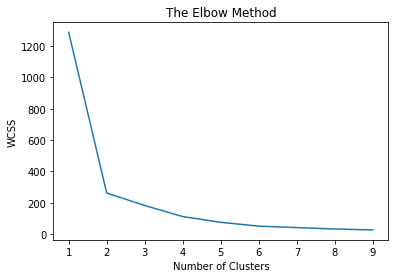

In [48]:
wcss=[]
s_score = []
for i in range(1,10):
    kmeans=KMeans(n_clusters=i, init='k-means++',random_state=0).fit(demand_orlando_zip[['zip_lat','zip_lon']])
#     kmeans.fit(demand_df[['lat_zip','lon_zip']].values, sample_weight = demand_df.volume.values)
    wcss.append(kmeans.inertia_)
#     if i == 1:
#         s_score.append(i)
#     else:
#         s_score.append(silhouette_score(demand_df[demand_df.assigned_clusters == 0][['lat_zip','lon_zip']].values, kmeans.fit_predict(demand_df[demand_df.assigned_clusters == 0][['lat_zip','lon_zip']])))
#     print(kmeans.cluster_centers_)
plt.plot(range(1,10),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

## 2) Contraint kmeans

In [36]:
def determine_clust_centroids(model, dataset):
    clusters_centroids=dict()
    clusters_radii= dict()

    for cluster in list(range(model.n_clusters)):

        clusters_centroids[cluster]=list(zip(model.cluster_centers_[:, 0],model.cluster_centers_[:,1]))[cluster]
        clusters_radii[cluster] = max([haversine(i,clusters_centroids[cluster]) for i in list(zip(dataset[dataset.assigned_clusters == cluster]['zip_lat'],dataset[dataset.assigned_clusters == cluster]['zip_lon']))])
    return(clusters_centroids,clusters_radii)

In [50]:
clf = KMeansConstrained(
     n_clusters=4,
     size_min=500,
     size_max=2500,
     random_state=0
)
demand_orlando_zip_nooutliers['assigned_clusters'] = clf.fit_predict(demand_orlando_zip_nooutliers[['zip_lat','zip_lon']])

In [51]:
demand_orlando_zip_nooutliers['assigned_clusters'].value_counts(normalize = True)

3    0.293755
0    0.283224
2    0.241467
1    0.181554
Name: assigned_clusters, dtype: float64

In [52]:
demand_orlando_zip_nooutliers["color_const"] = demand_orlando_zip_nooutliers.assigned_clusters.apply(regioncolors)

In [53]:
clusters_centroids_clf, clusters_radii_clf = determine_clust_centroids(clf, demand_orlando_zip_nooutliers)

In [42]:
# #Locate centroids based on population covered in 30miles

# def popu_in_30_mins(s_df):
# #     print(s_df)
#     # This function gets all zip codes within 30mins driving distance of each zip and sums the population.
#     empty_list = []
#     for index, each in s_df.iterrows():
#     #     print(each.cust_zip)
#         demand_within_30mins = 0
#         for index, row in s_df.iterrows():
# #             print(haversine((each.zip_lat,each.zip_lon), (row.zip_lat,row.zip_lon), unit=Unit.MILES))
#             if haversine((each.zip_lat,each.zip_lon), (row.zip_lat,row.zip_lon), unit=Unit.MILES) <= 30.0:
#     #             print(analysis( each.Longitude,each.Latitude,  row.Longitude,row.Latitude)[1])
#     #             print(each.claim_volume)
#                 demand_within_30mins = demand_within_30mins+1
# #                 print(demand_within_30mins)
#     #     print(demand_within_30mins)
#         empty_list.append(demand_within_30mins)
# #     print(empty_list)
#     return(empty_list)

# demand_orlando_zip_nooutliers['Population_w_30mins'] = popu_in_30_mins(demand_orlando_zip_nooutliers)

# derived_centroids = {}
# for index, each in demand_orlando_zip_nooutliers.groupby('assigned_clusters')['Population_w_30mins'].idxmax().reset_index().iterrows():
#     derived_centroids[each.assigned_clusters] =  (demand_orlando_zip_nooutliers[demand_orlando_zip_nooutliers.index == each.Population_w_30mins]['zip_lat'].values[0], demand_orlando_zip_nooutliers[demand_orlando_zip_nooutliers.index == each.Population_w_30mins]['zip_lon'].values[0])
    

In [60]:
m_constraints = folium.Map(location=[demand_orlando_zip_nooutliers.zip_lat.iloc[0],demand_orlando_zip_nooutliers.zip_lon.iloc[0]], zoom_start=8)

In [61]:
HeatMap(demand_orlando_zip[['zip_lat','zip_lon']], name = 'Population Density').add_to(m_constraints)

In [55]:
for i in clusters_centroids_clf:
    folium.Marker(location=[clusters_centroids_clf[i][0],clusters_centroids_clf[i][1]],
                  popup="Cluster #"+str(i),
    icon=folium.Icon(icon="info-sign",  color = "green"),).add_to(m_constraints)

In [56]:
for lt, ln, color in zip(demand_orlando_zip_nooutliers.zip_lat, demand_orlando_zip_nooutliers.zip_lon, demand_orlando_zip_nooutliers.color_const):
    cm = folium.CircleMarker(location=[lt, ln],
                            radius = 6,
#                             popup=str(el)+" m",
                            fill=True, # Set fill to True
                            fill_color=color,
                            color = color,
                            fill_opacity=0.7,
                            line_opacity=0.7)
    m_constraints.add_child(cm)

In [57]:
m_constraints

In [62]:
m_constraints.save('Maps/tampa/tampa_heatmap.html')

In [64]:
def plot_clusters_on_map(init_lat, init_lon, dataset, centroid_dict, name, model):
    # initialize the map and store it in a m object
    m = folium.Map(location=[init_lat,init_lon], zoom_start=8)
    

    tablular_analysis_clusters = pd.DataFrame()
    for rec in range(dataset.assigned_clusters.max()+1):
        print(rec)
        Cluster_df = dataset[dataset.assigned_clusters == rec]
        Cluster_df['distance'] = function_distance(Cluster_df, centroid_dict[rec])
        Cluster_df['distance_from_centroid'] = dist_from_centroid(Cluster_df, centroid_dict[rec])

        print('Farthest point for cluster: ',+Cluster_df[Cluster_df.distance == Cluster_df.distance.max()]['distance'].values[0])
#         print('Average driving distance: ', round(average( Cluster_df['distance_from_centroid'], weights = Cluster_df['volume']),2))
    #     print('Population covered under 30 miles',+Cluster_df[Cluster_df['distance_from_centroid']<30.0]['Population'].sum()/Cluster_df['Population'].sum())

        tablular_analysis = pd.DataFrame()
        tablular_analysis['cluster number'] = Cluster_df.assigned_clusters.unique()
        tablular_analysis['cluster population'] = Cluster_df.shape[0]
        tablular_analysis['% population in cluster'] = Cluster_df.shape[0]/dataset.shape[0]
        tablular_analysis['weighted avg driving distance'] = round(average( Cluster_df['distance_from_centroid']),2)
        tablular_analysis['population covered by driving distance'] = Cluster_df[Cluster_df.distance<=tablular_analysis['weighted avg driving distance'].values[0]].shape[0]
        tablular_analysis['% population covered by avg driving distance'] = Cluster_df[Cluster_df.distance<=tablular_analysis['weighted avg driving distance'].values[0]].shape[0]/Cluster_df.shape[0]
        tablular_analysis['farthest point in cluster'] = Cluster_df[Cluster_df.distance == Cluster_df.distance.max()]['distance'].values[0]
        tablular_analysis['farthest point lat']  = Cluster_df[Cluster_df.distance == Cluster_df.distance.max()]['zip_lat'].values[0]
        tablular_analysis['farthest point long']  = Cluster_df[Cluster_df.distance == Cluster_df.distance.max()]['zip_lon'].values[0]
        tablular_analysis['centroid lat'] = list(zip(model.cluster_centers_[:, 0],model.cluster_centers_[:,1]))[rec][0]
        tablular_analysis['centroid long'] = list(zip(model.cluster_centers_[:, 0],model.cluster_centers_[:,1]))[rec][1]
        # Appending cluster wise analysis
        tablular_analysis_clusters = tablular_analysis_clusters.append(tablular_analysis)

        # Adding circle on map to show area covered by avg driving distance
        folium.CircleMarker(
            location=[tablular_analysis['farthest point lat'], tablular_analysis['farthest point long']],
            radius=5,
            popup=str(Cluster_df[Cluster_df.distance == Cluster_df.distance.max()]['distance'].values[0])+" miles",
            color="crimson",
            fill=True,
            fill_color="crimson",
        ).add_to(m)
#         radius = tablular_analysis['weighted avg driving distance'].values[0]*1609.34
        radius = tablular_analysis['farthest point in cluster'].values[0]*1609.34
        folium.Circle(location=(tablular_analysis['centroid lat'],tablular_analysis['centroid long']), radius=radius).add_to(m)
    m.add_child(plugins.HeatMap(dataset[['zip_lat','zip_lon']].values, radius=15))
    
    tablular_analysis_clusters.to_excel('Maps/Tampa/{}.xlsx'.format(name))
    
    for i in centroid_dict:
#     print(clusters_centroids[i][0],clusters_centroids[i][1])
        folium.Marker(location=[centroid_dict[i][0],centroid_dict[i][1]],
                  popup="Cluster #"+str(i),
                  icon=folium.Icon(icon="info-sign",  color = "green"),).add_to(m)
#     m.save('Maps/tamps/{}.html'.format(name))

In [65]:
plot_clusters_on_map(demand_orlando_zip_nooutliers.zip_lat.iloc[0],demand_orlando_zip_nooutliers.zip_lon.iloc[0], demand_orlando_zip_nooutliers, clusters_centroids_clf, 'constraint_kmeans_cust_locations', clf)

0
Farthest point for cluster:  13.142099967813529
1
Farthest point for cluster:  19.459757734412083
2
Farthest point for cluster:  11.542012529983516
3
Farthest point for cluster:  14.933478297335704


In [393]:
m_db.save('Maps/orlando_kmeans/dbscan_onCustAddresses.html')

# HDBSCAN

In [76]:
import hdbscan
import seaborn as sns
from sklearn.metrics.pairwise import haversine_distances
distance_matrix = haversine_distances(demand_orlando_zip_nooutliers[['zip_lat','zip_lon']].values)

In [100]:
clusterer = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=50).fit(distance_matrix)
print(clusterer.labels_.max()+1)
color_palette = sns.color_palette('deep', clusterer.labels_.max() +1)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

12


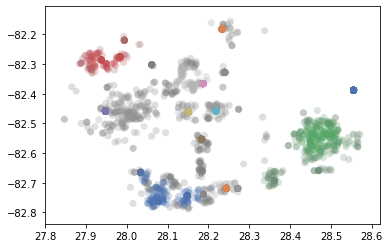

In [101]:
plt.scatter(x=demand_orlando_zip_nooutliers['zip_lat'], y=demand_orlando_zip_nooutliers['zip_lon'], s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

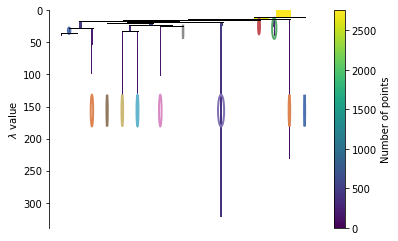

In [104]:
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', clusterer.labels_.max() +1))

In [106]:
clusterer.single_linkage_tree_